In [1]:
## ignore this ##
# import the libraries we use in this program
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
big_num = 10000000 # a big number, similar to 1/epsilon

In [3]:
# A few keys on syntax:
# random.random() <- the way to generate a random number in python
# -np.log(1-random.random())/lam  <- the way to get an exponential random number with lambda

In [4]:
# define the parameters
T = 300 # total_time_of_simulation
lam = 0.66667 # lambda or the arrival rate in (customers/minute)
mu = 0.41667 # mu or the departure rate in (customers/minute)

In [5]:
# initialise the counter variables
t = 0 # the clock
N = 0 # the number of customers in system at any given time
N_A = 0 # the cumulative number of arrivals to the system

In [6]:
## ignore this ##
# a function to generate a random interarrival time based on uniform random variable 
def random_arrival():
    random_arrival_time = -np.log(1-random.random())/lam
    return random_arrival_time
# a function to generate a random service completion time based on uniform random variable 
def random_service():
    random_service_time = -np.log(1-random.random())/mu
    return random_service_time

In [7]:
# Generate the first event
t_a = t + random_arrival()
t_d_1 = big_num # departure due to service completion at server 1, initialized to big_num
t_d_2 = big_num # departure due to service completion at server 2, initialized to big_num
t_s = 0 # temporary container for service time

In [8]:
# Important
# Customers_1 and Customers_2 are hash tables to record customers coming to each of the servers
Customers_1 = {} # customers served by server 1
Customers_2 = {} # customers served by server 2

# for customers who have just arrived and not assigned a server yet
unassigned_time = [] # temp storage for arrival time of unassigned customer
unassigned_customer = [] # temp storage for customer ID(nth customer) of unassigned customer

In [9]:
# we iterate until the simulation ends, and keep track of the min of all times < T
while min(t_a, t_d_1, t_d_2) <=T:
    
    # if the next event is an arrival
    if t_a <= min(t_d_1, t_d_2, T):

        N_A = N_A + 1 # update arrival counter
        t = t_a # update clock
        N = N + 1 # update customers in system counter

        unassigned_time.append(t) # add the newly arrived customer to the unassigned list
        unassigned_customer.append(N_A) # add the newly arrived customer to the unassigned list

        t_a = t + random_arrival() # generate new arrival event time

        # generate new service completion time if triggered
        if N==1 : # newly arrived customer begins service immediately
            t_s = random_service() # calculate service time
            # randomly choose one of the servers for service completion
            if random.random() < 0.5: # bernoulli trial to choose server 1
                # record the arrival time, the time of reaching service ounter and the service time
                Customers_1[unassigned_customer.pop(0)] = [unassigned_time.pop(0), t, t_s]
                t_d_1 = t + t_s # update time for next service completion at server 1
            else: # bernoulli trial to choose server 2
                # record the arrival time, the time of reaching service ounter and the service time
                Customers_2[unassigned_customer.pop(0)] = [unassigned_time.pop(0), t, t_s] 
                t_d_2 = t + t_s # update time for next service completion at server 2
        if N==2 : # newly arrived customer begins service immediately
            t_s = random_service() # calculate service time
            # check if server 1 is currently free
            if t_d_1 >= big_num:
                # record the arrival time, the time of reaching service ounter and the service time
                Customers_1[unassigned_customer.pop(0)] = [unassigned_time.pop(0), t, t_s] 
                t_d_1 = t + t_s # update time for next service completion at server 1
            # it seems that server 2 is free
            else:
                # record the arrival time, the time of reaching service ounter and the service time
                Customers_2[unassigned_customer.pop(0)] = [unassigned_time.pop(0), t, t_s] 
                t_d_2 = t + t_s # update time for next service completion at server 2

    # if the next event is a service completion at server 1
    if t_d_1 <= min(t_a, t_d_2, T):

        t = t_d_1 # update clock
        N = N - 1 # update customers in system counter

        if N == 0: # noone in the system to serve, assign big number to t_d_1
            t_d_1 = big_num
            t_d_2 = big_num
        elif N==1: # only one person, and is being served at server 2, assign big number to t_d_1
            t_d_1 = big_num
        else: # serve the next customer
            t_s = random_service() # calculate service time
            # record the arrival time, the time of reaching service ounter and the service time
            Customers_1[unassigned_customer.pop(0)] = [unassigned_time.pop(0), t, t_s] 
            t_d_1 = t + t_s # update time for next service completion at server 1

    # if the next event is a service completion at server 2
    if t_d_2 <= min(t_a, t_d_1, T):

        t = t_d_2 # update clock
        N = N - 1 # update customers in system counter

        if N == 0: # noone in the system to serve, assign big number to t_d_2
            t_d_2 = big_num
        elif N == 1: # only one person, and is being served at server 1, assign big number to t_d_2
            t_d_2 = big_num
        else:
            t_s = random_service() # calculate service time
            # record the arrival time, the time of reaching service ounter and the service time
            Customers_2[unassigned_customer.pop(0)] = [unassigned_time.pop(0), t, t_s] 
            t_d_2 = t + t_s # update time for next service completion at server 2
t = T #end of simulation

In [10]:
## ignore
# merge the customer lists
def merge_dict(x, y):
    z = x.copy()
    z.update(y)
    return z
Customers = merge_dict(Customers_1, Customers_2)
Customers = pd.DataFrame.from_dict(Customers, orient='index')
Customers.columns = ["Arrival_Time", "CounterReach_Time", "Service_Time"]

In [11]:
# compute the time spent in the queue for all customers
Customers["Queue_Time"] = Customers["CounterReach_Time"] - Customers["Arrival_Time"]

In [12]:
# compute the departure time of all the customers
Customers["Departure_Time"] = Customers["Queue_Time"] + Customers["Service_Time"] + Customers["Arrival_Time"]

In [13]:
# Calculate time statistics only for customers who complete service before time T
Customers = Customers.query("Departure_Time <= @T")

In [14]:
# compute the total time spent in the system for each customer
Customers["System_Time"] = Customers["Departure_Time"] - Customers["Arrival_Time"]
# compute the arrival headways
Customers["Arrival_Headway"] = Customers["Arrival_Time"] - Customers["Arrival_Time"].shift(1)
Customers["Arrival_Headway"][1] = 0

In [15]:
Customers.head(5) # this is how the data looks

,Arrival_Time,CounterReach_Time,Service_Time,Queue_Time,Departure_Time,System_Time,Arrival_Headway
1,0.613579,0.613579,3.351442,0.000000,3.965021,3.351442,0.000000
2,1.822052,1.822052,1.444887,0.000000,3.266939,1.444887,1.208473
3,2.064306,3.266939,0.857123,1.202633,4.124062,2.059757,0.242254
4,3.537251,3.965021,4.285645,0.427770,8.250666,4.713414,1.472946
5,4.099896,4.124062,1.711684,0.024166,5.835746,1.735850,0.562644


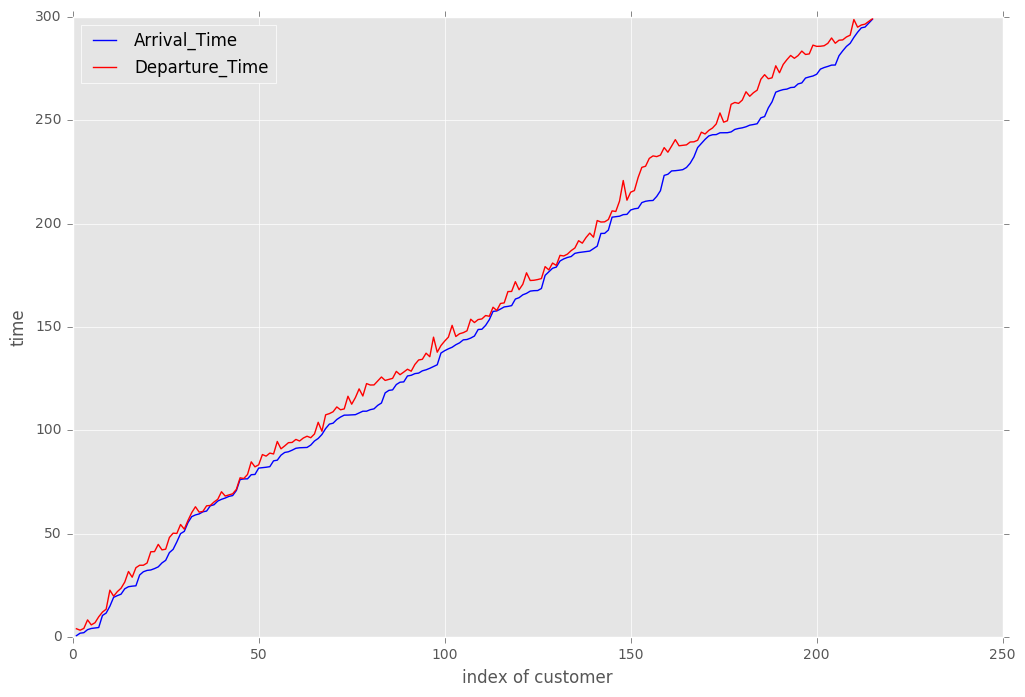

In [16]:
# plot the cumulative arrival and departure times
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))
axes = plt.axes()
plt.xlabel("index of customer")
plt.ylabel("time")
plt.plot(Customers["Arrival_Time"], 'b')
plt.plot(Customers["Departure_Time"], 'r')
plt.legend(["Arrival_Time", "Departure_Time"], loc = "best")
plt.show()
#plt.savefig("Error and without.png", format="png")

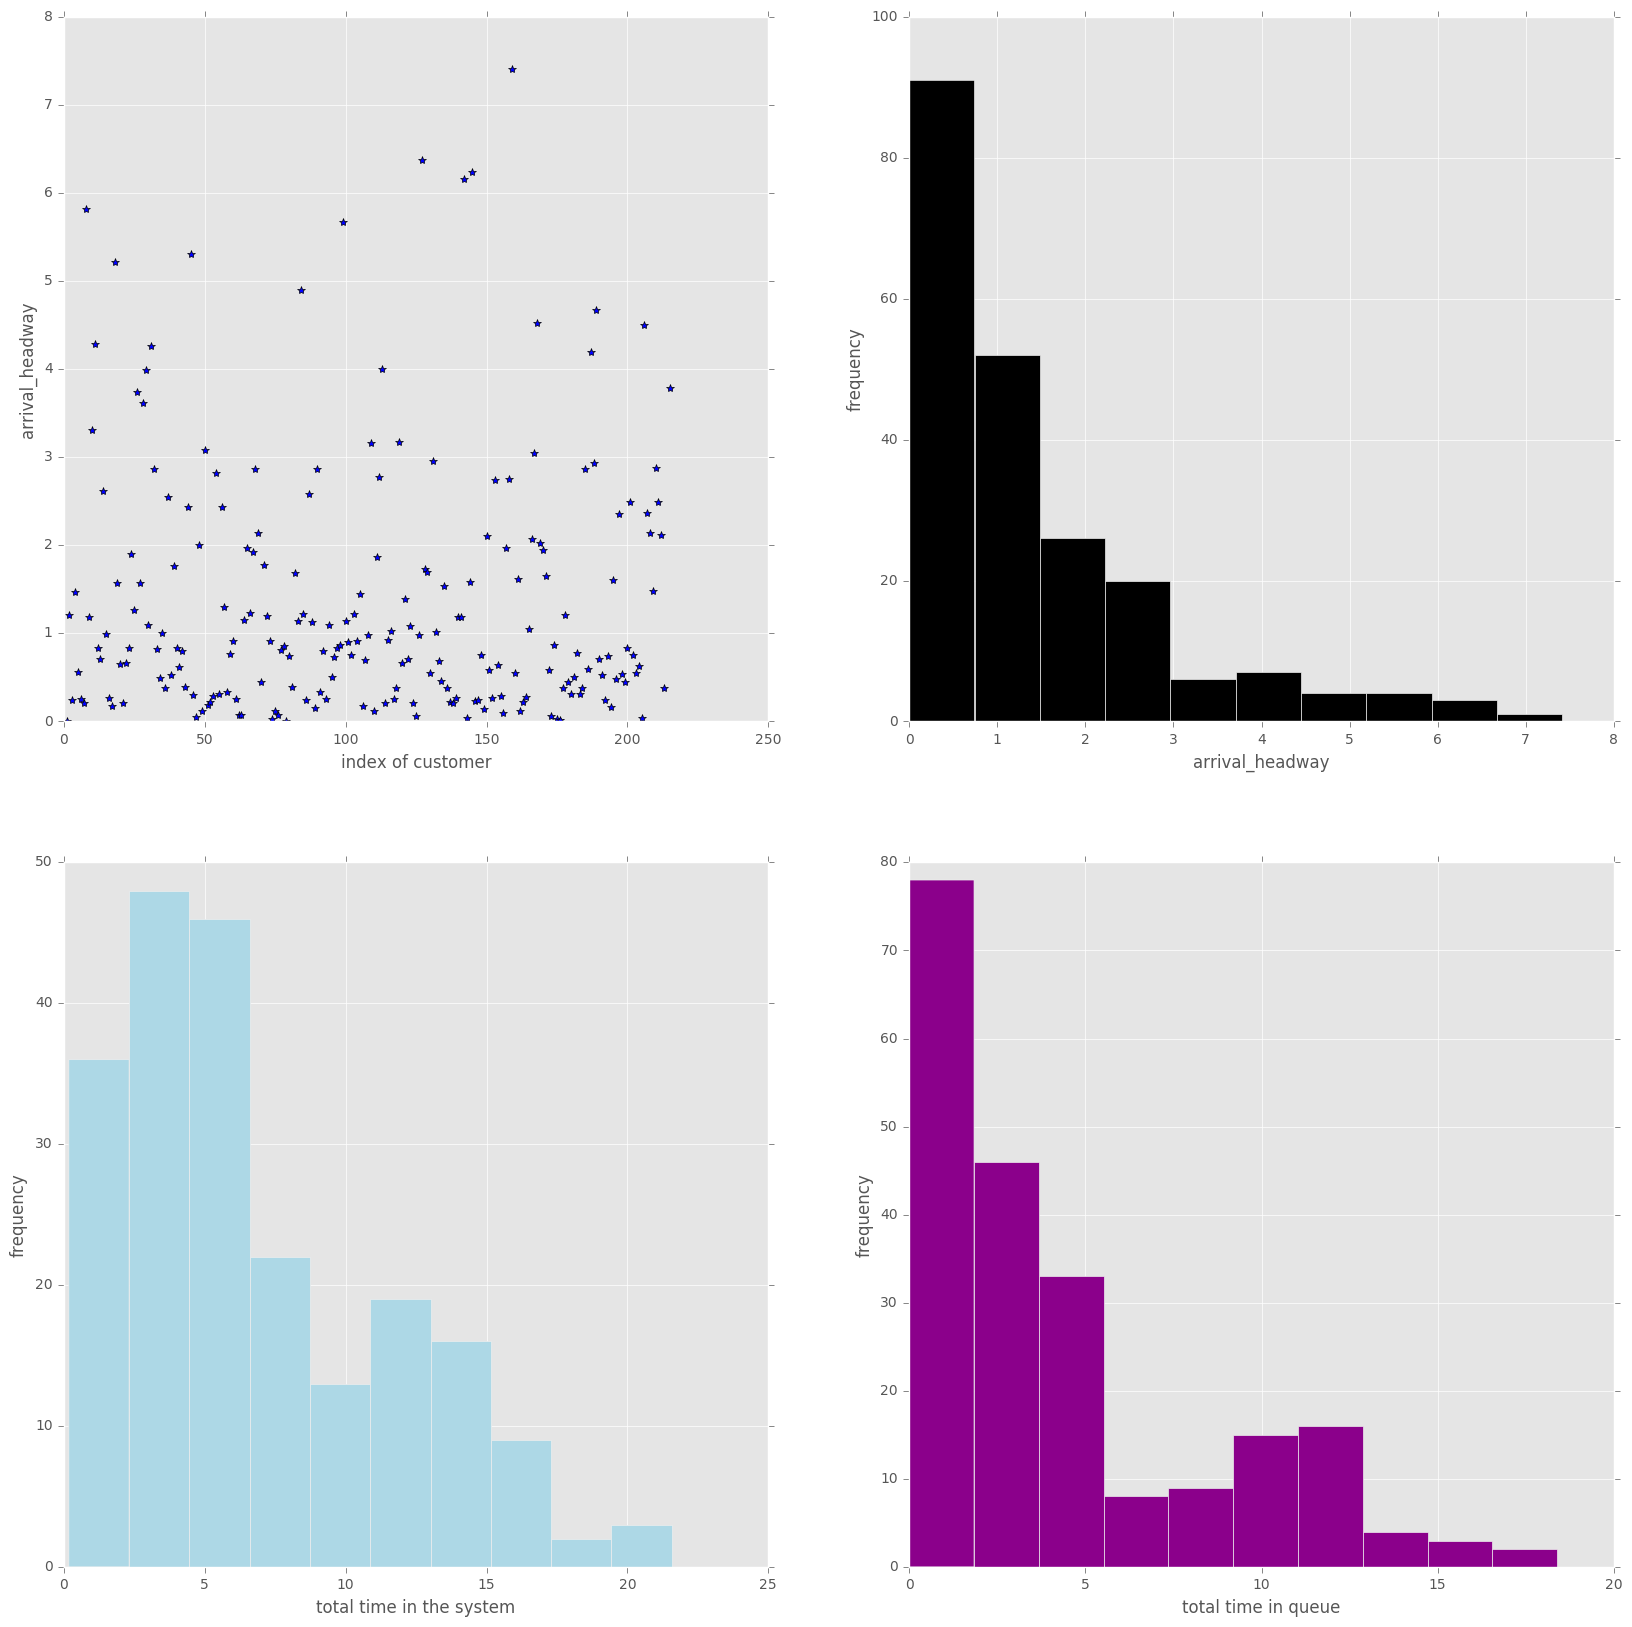

In [17]:
# Generate plots and histograms
plt.style.use('ggplot')
plt.figure(1)
plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.plot(Customers["Arrival_Headway"], 'b*')
plt.xlabel("index of customer")
plt.ylabel("arrival_headway")

plt.subplot(222)
plt.hist(Customers["Arrival_Headway"], bins=10, color='k')
plt.xlabel("arrival_headway")
plt.ylabel("frequency")

plt.subplot(223)
plt.hist(Customers["System_Time"], bins=10, color='lightblue')
plt.xlabel("total time in the system")
plt.ylabel("frequency")

plt.subplot(224)
plt.hist(Customers["Queue_Time"], bins=10, color='darkmagenta')
plt.xlabel("total time in queue")
plt.ylabel("frequency")

plt.show()

In [18]:
# Calculate system statistics for average time spent per user
T_bar = np.mean(Customers["System_Time"]) # calculate average time spent in system
T_max = max(Customers["System_Time"])
T_Q_bar = np.mean(Customers["Queue_Time"]) # calculate average time spent in queue

In [19]:
# Calculate system statistics for number of customers in system per time
time_bin = [i for i in range(T)]
N_S = map(lambda x: len(Customers.query("Arrival_Time < @x & Departure_Time > @x")),time_bin) # number of customers in system indexed by minute
N_Q = map(lambda x: len(Customers.query("Arrival_Time < @x & CounterReach_Time > @x")),time_bin) # number of customers in queue indexed by minute
N_S_bar = np.mean(N_S) # calculate average number of customers in system
N_Q_bar = np.mean(N_Q) # calculate average number of customers in queue

In [20]:
# print simulator output statistics
print 'Average time in system: ', T_bar
print 'Maximum time in system per customer: ', T_max
print 'Average time in queue: ', T_Q_bar
print 'Average number of customers in system: ', N_S_bar
print 'Average number of customers in queue: ', N_Q_bar

Average time in system:  6.76022276945
Maximum time in system per customer:  21.5673015225
Average time in queue:  4.28238990915
Average number of customers in system:  4.83666666667
Average number of customers in queue:  3.06
